# Domaci zadatak 3 - Neuronske mreze

<b>Studenti: Vladan Milojević - 1248, Vladimir Nešić - 1235</b>

Cilj projekta je predviđanje smrtnog ishoda kod pacijenata koji su doživeli zastoj srca. Dataset koji se koristi: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

Da bi dataset bio balansiran, generisani su podaci uz pomoc SMOTE filtera u Weka programu.

### Korišćene biblioteke, učitavanje i analiza podataka

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, plot_roc_curve
import matplotlib.pyplot as plt  
import tensorflow as tf
from tensorflow import keras
from keras.layers import Bidirectional, Dense, Dropout
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.callbacks import TensorBoard
from keras_visualizer import visualizer 
from time import time
import keras.backend as K

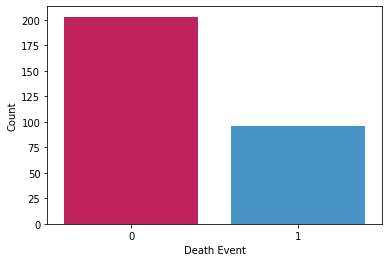

In [165]:
#loading data
unbalanced_data = pd.read_csv("heart_failure_clinical_records_dataset.csv")
unbalanced_data.head()

sns.countplot(x="DEATH_EVENT",data=unbalanced_data,palette=["#DA0858","#3498DB"])
plt.ylabel("Count")
plt.xlabel("Death Event")
plt.show()

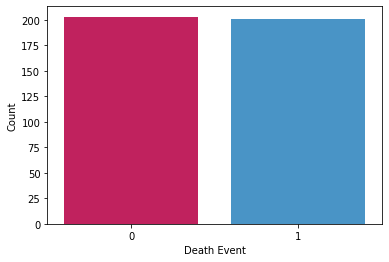

In [174]:
#loading data
data = pd.read_csv("heart_failure_clinical_records_dataset_balanced.csv")
data.head()

sns.countplot(x="DEATH_EVENT",data=data,palette=["#DA0858","#3498DB"])
plt.ylabel("Count")
plt.xlabel("Death Event")
plt.show()

In [167]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,60.676569,0.408416,491.779703,0.391089,35.690594,0.319307,238623.032525,1.366312,135.980198,0.665842,0.240099,101.349010,0.497525
std,12.083863,0.492150,855.137273,0.488599,11.640854,0.466786,100308.923793,0.923587,4.268251,0.472280,0.427673,83.131839,0.500614
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.500000,113.000000,0.000000,0.000000,4.000000,0.000000
25%,50.000000,0.000000,104.000000,0.000000,25.000000,0.000000,173750.000000,1.000000,134.000000,0.000000,0.000000,23.750000,0.000000
50%,60.000000,0.000000,201.500000,0.000000,35.000000,0.000000,235000.000000,1.100000,136.000000,1.000000,0.000000,85.500000,0.000000
75%,70.000000,1.000000,582.000000,1.000000,40.000000,1.000000,279000.000000,1.400000,139.000000,1.000000,0.000000,186.000000,1.000000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.400000,148.000000,1.000000,1.000000,285.000000,1.000000


In [168]:
data.isnull().any()

age                         False
anaemia                     False
creatinine_phosphokinase    False
diabetes                    False
ejection_fraction           False
high_blood_pressure         False
platelets                   False
serum_creatinine            False
serum_sodium                False
sex                         False
smoking                     False
time                        False
DEATH_EVENT                 False
dtype: bool

In [169]:
data.corr()["DEATH_EVENT"].abs().nlargest(20)

DEATH_EVENT                 1.000000
time                        0.689805
ejection_fraction           0.395489
serum_sodium                0.291508
platelets                   0.281216
smoking                     0.200041
serum_creatinine            0.197666
age                         0.159432
diabetes                    0.056901
creatinine_phosphokinase    0.056803
sex                         0.033226
high_blood_pressure         0.012538
anaemia                     0.000922
Name: DEATH_EVENT, dtype: float64

### Priprema podataka

In [170]:
X=data.drop(["DEATH_EVENT"],axis=1)
y=data["DEATH_EVENT"]

#Standard scaler features of the dataset
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)   
X_df.describe().T

#Spliting test and training sets
X_train, X_test, y_train,y_test = train_test_split(X_df,y,test_size=0.3,random_state=0)

def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))

### Train model and print metrics

In [171]:
def train_model_and_print_metrics(model, X_train, X_test, y_train, y_test):
    history = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_split=0.2)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    test_loss, test_acc = model.evaluate(X_test, y_test)
    target_names = ['0', '1']

    print(classification_report(y_test, y_pred, target_names=target_names))

    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    print('Test loss: ', test_loss)
    print('Test accuracy: ', test_acc)

### Loss funkcije

In [172]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))

def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))


def custom_mse(y_true, y_pred):
 
    # calculating squared difference between target and predicted values 
    loss = K.square(y_pred - y_true)  # (batch_size, 2)
    
    # multiplying the values with weights along batch dimension
    loss = loss * [0.3, 0.7]          # (batch_size, 2)
                
    # summing both loss values along batch dimension 
    loss = K.sum(loss, axis=1)        # (batch_size,)
    
    return loss


### Kreiranje i treniranje modela

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_257 (Dense)            (None, 9)                 117       
_________________________________________________________________
dense_258 (Dense)            (None, 7)                 70        
_________________________________________________________________
dense_259 (Dense)            (None, 5)                 40        
_________________________________________________________________
dropout_65 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_260 (Dense)            (None, 1)                 6         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________
None
Train on 225 samples, validate on 57 samples
Epoch 1/100
225/225 [==============================] - 2s 9ms/step - lo

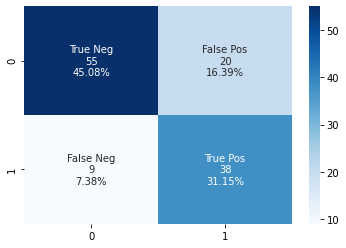

In [173]:
model = Sequential()

model.add(Dense(units = 9, activation = 'relu', input_dim = 12))
# model.add(Dropout(0.1))
model.add(Dense(units = 7, activation = 'relu'))
model.add(Dense(units = 5, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 1, activation = 'sigmoid'))

print(model.summary())

model.compile(optimizer = 'adam', loss = custom_mean_squared_error, metrics = ['accuracy'])

train_model_and_print_metrics(model, X_train, X_test, y_train, y_test)
